# Data Mining/Machine Learning Project: Medical Appointments - No Show

## Goals
1. Given a set of attributes/factors, predict if a person will miss their appointment or not.
2. Determine what factors contribute the most to a person missing their appointment.
3. Compare the performance of the 2 data mining/analysis methods implemented for this project.

##I. Business Understanding

Missed appointments are costly on the medical institutions. Therefore, understanding the factors that cause no-shows are vital in the search for potential solutions to these problems. Having the information about the data set have the following benefits:

1. Hospital can intelligently send more reminders to patients at a higher risk of missing appointments.
2. Understand if the reminder methods (in this case: SMS) are effective or not, and make changes as necessary to the strategies.
3. Inform appointment management/scheduling strategy. (More on the day or more routine appointments?)

## II. Data Understanding
### Dataset:
The dataset contains information about medical appointments and has 14 variables (PatientId, AppointmentID, Gender, DateScheduled, AppointmentDate, Age, Neighborhood, Scholarship, Hypertension, Diabetes, Alcoholism, Handicap, SMSReceived, NoShow).

### Tasks:

Explore the dataset to understand its structure, size, and features.
Check for missing values, outliers, and data types.
Understand the distribution of the target variable (NoShow).
Explore and analyze the relationships between features and the target variable.

In [1]:
# Load the required libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 2000)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data into a pandas dataframe
df = pd.read_csv('dataset.csv')


## Data Size, Dimensionality, Size, Data types
The dataset provided by [source] has a 110527 x 14 (mxn) dimensionality. We can identify the following columns and their data types (as nominal, ordinal, or continuous):
1. PatientId: nominal
2. AppointmentID: nominal
3. Gender: nominal
4. ScheduledDay: date type
5. AppointmentDay: date type
6. Age: continuous
7. Neighbourhood: nominal
8. Scholarship: nominal
9. Hypertension: nominal
10. Diabetes: nominal
11. Alcoholism: nominal
12. Handcap: nominal
13. SMS_received: nominal
14. No-show: nominal

In [3]:
# Dataset shape
df.shape

(110527, 14)

In [4]:
# First 5 rows of the dataset
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


The dataset has 14 columns or characteristics.

In [5]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


In [6]:
# List columns in the dataset
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'], dtype='object')

In [7]:
# Duplication check
df.duplicated().sum()

0

## Dataframe overall information
The dataset has no missing values across all rows and columns.

In [8]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [9]:

df.drop(columns=['AppointmentID'], inplace=True, axis=1)
# df.drop_duplicates(['PatientId','No-show'], inplace = True)
# df.reset_index(drop=True, inplace=True)
df.shape

(110527, 13)

In [10]:
## rename columns to fix typos and use pythonic naming conventions
column_rename_dict = {}
for column in df.columns:
    column_rename_dict[column] = column.lower().replace(' ', '_')
    if '-' in column_rename_dict[column]:
        column_rename_dict[column] = column_rename_dict[column].replace('-', '_')

column_rename_dict['Hipertension'] = 'hypertension'
column_rename_dict['Handcap'] = 'handicap'
column_rename_dict['AppointmentDay'] = 'appointment_day'
column_rename_dict['ScheduledDay'] = 'scheduled_day'
column_rename_dict['PatientId'] = 'patient_id'

df.rename(columns=column_rename_dict, inplace=True)
# Check
df.columns


Index(['patient_id', 'gender', 'scheduled_day', 'appointment_day', 'age', 'neighbourhood', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show'], dtype='object')

## Descriptive Statistics
1. Minimum age is -1 which is not possible.
2. Scholarship, Hypertension, Diabetes are binary for all rows. But Handicap has a max value of 4. This could mean this attribute should be binary and these >1 values are errors or it means the number of handicaps the patient had. The description provided from the source via Kaggle states it should be represented as True or False, but the Discussions revealed the attribute is the number of handicaps the patient has.

In [11]:
df[df.select_dtypes(exclude='object').columns.drop(["patient_id"])].describe().T

,count,mean,std,min,25%,50%,75%,max
age,110527.0,37.088874,23.110205,-1.0,18.0,37.0,55.0,115.0
scholarship,110527.0,0.098266,0.297675,0.0,0.0,0.0,0.0,1.0
hypertension,110527.0,0.197246,0.397921,0.0,0.0,0.0,0.0,1.0
diabetes,110527.0,0.071865,0.258265,0.0,0.0,0.0,0.0,1.0
alcoholism,110527.0,0.030400,0.171686,0.0,0.0,0.0,0.0,1.0
handicap,110527.0,0.022248,0.161543,0.0,0.0,0.0,0.0,4.0
sms_received,110527.0,0.321026,0.466873,0.0,0.0,0.0,1.0,1.0


In [12]:
num_cols_no_age = df.select_dtypes(exclude='object').columns.drop(['patient_id', 'age'])

# Concatenate the percentage distribution data for all columns
perc_dist = pd.concat([pd.DataFrame({f"{column} value": df[column].value_counts(normalize=True).index,
                                                f"{column} percentage %": (df[column].value_counts(normalize=True) * 100).round(4).values})
                                  for column in num_cols_no_age], axis=1)
perc_dist = perc_dist.fillna(0)

perc_dist

,scholarship value,scholarship percentage %,hypertension value,hypertension percentage %,diabetes value,diabetes percentage %,alcoholism value,alcoholism percentage %,handicap value,handicap percentage %,sms_received value,sms_received percentage %
0,0.0,90.1734,0.0,80.2754,0.0,92.8135,0.0,96.96,0,97.9724,0.0,67.8974
1,1.0,9.8266,1.0,19.7246,1.0,7.1865,1.0,3.04,1,1.8475,1.0,32.1026
2,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.00,2,0.1656,0.0,0.0000
3,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.00,3,0.0118,0.0,0.0000
4,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.00,4,0.0027,0.0,0.0000


## Data Cleaning
The goal is to remove anomalies from the data to develop data quality. Since in the descriptive statistics check an anomaly was observed in both the age and handicap columns, data cleaning operation can be performed in these columns. We can also ensure date type columns are converted correctly to datetime.
### Steps:
1. Remove the row will the age = -1. Manual removal is done here as it is simply 1 record with this issue and will not significantly impact the age column in correlation to the target variable for data modeling.
2. Convert scheduled_day and appointment_day columns to datetime.


In [13]:
# Remove rows with negative age
df.query("age == -1")

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,4.659432e+14,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


Check if there are enough rows in the dataset for ROMÃO. If that's the case, the loss is negligible.

In [14]:
df[df['neighbourhood'] ==  "ROMÃO"].value_counts()

patient_id    gender  scheduled_day         appointment_day       age  neighbourhood  scholarship  hypertension  diabetes  alcoholism  handicap  sms_received  no_show
6.797656e+14  M       2016-04-27T09:35:44Z  2016-06-01T00:00:00Z  86   ROMÃO          0            1             0         0           0         0             Yes        5
9.773989e+11  M       2016-04-11T07:54:21Z  2016-05-19T00:00:00Z  5    ROMÃO          0            0             0         0           0         0             No         2
1.123837e+13  F       2016-05-09T14:21:41Z  2016-05-13T00:00:00Z  28   ROMÃO          0            1             0         0           0         0             No         2
3.621860e+11  F       2016-05-09T13:52:50Z  2016-05-12T00:00:00Z  57   ROMÃO          0            1             1         0           0         0             No         2
4.343554e+14  M       2016-05-09T10:18:10Z  2016-05-19T00:00:00Z  8    ROMÃO          0            0             0         0           0         

In [15]:
# Drop row with negative age
from matplotlib import axis



df.drop(df[df['age']< 0].index, inplace = True)
df.reset_index(drop=True, inplace=True)
print(df.tail())
df.shape

          patient_id gender         scheduled_day       appointment_day  age neighbourhood  scholarship  hypertension  diabetes  alcoholism  handicap  sms_received no_show
110521  2.572134e+12      F  2016-05-03T09:15:35Z  2016-06-07T00:00:00Z   56   MARIA ORTIZ            0             0         0           0         0             1      No
110522  3.596266e+12      F  2016-05-03T07:27:33Z  2016-06-07T00:00:00Z   51   MARIA ORTIZ            0             0         0           0         0             1      No
110523  1.557663e+13      F  2016-04-27T16:03:52Z  2016-06-07T00:00:00Z   21   MARIA ORTIZ            0             0         0           0         0             1      No
110524  9.213493e+13      F  2016-04-27T15:09:23Z  2016-06-07T00:00:00Z   38   MARIA ORTIZ            0             0         0           0         0             1      No
110525  3.775115e+14      F  2016-04-27T13:30:56Z  2016-06-07T00:00:00Z   54   MARIA ORTIZ            0             0         0           0 

(110526, 13)

In [16]:
# Convert the scheduled_day and appointment_day columns to datetime
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])

In [17]:
nominal_columns = df.select_dtypes(include='object').columns
numerical_columns =df.select_dtypes(exclude='object').columns

nominal_cols_list = nominal_columns.tolist()
num_cols_list = numerical_columns.tolist()
numerical_columns

Index(['patient_id', 'scheduled_day', 'appointment_day', 'age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received'], dtype='object')

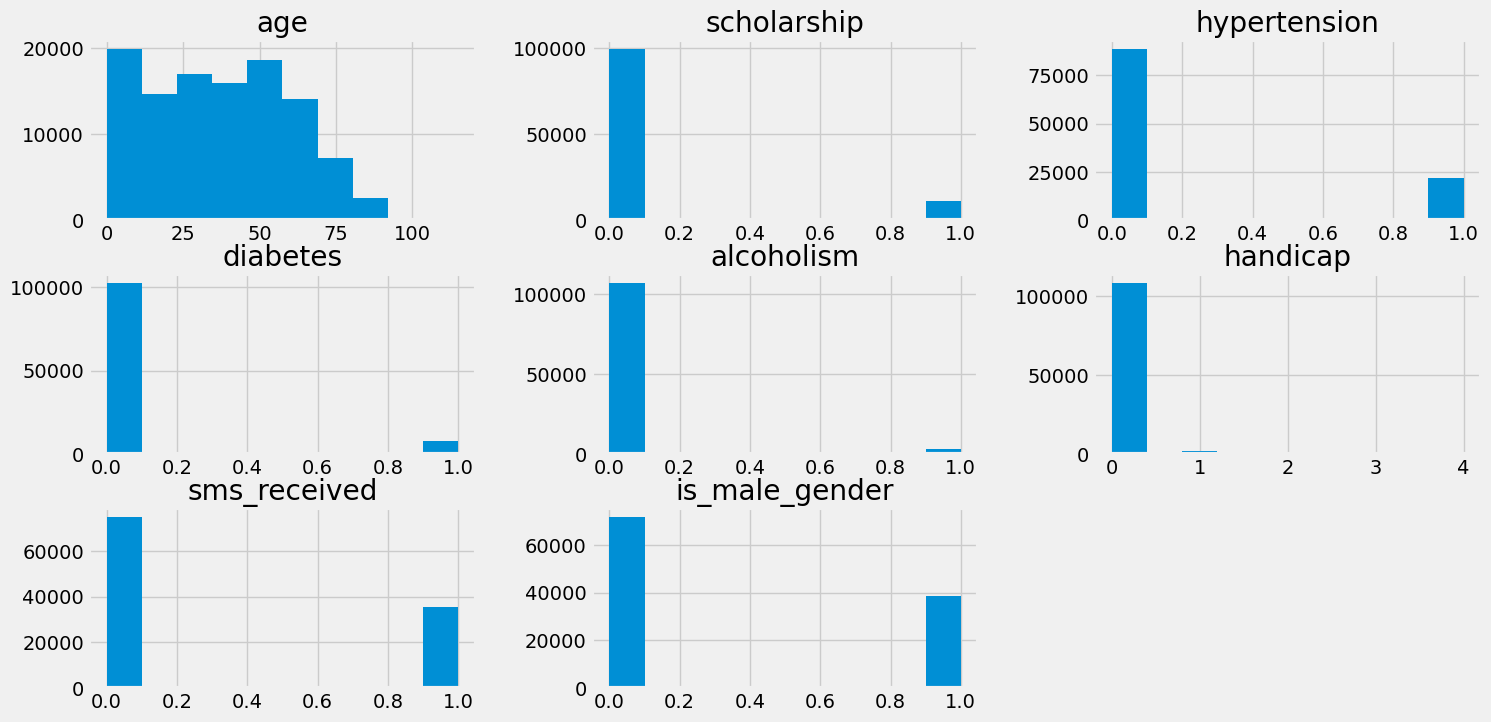

In [18]:
df["is_male_gender"] = df['gender'].map({'M': 1, 'F': 0})
df[df.columns.drop(['patient_id', 'appointment_day', 'scheduled_day'])].hist(figsize=(16,8))
df.drop(columns=['is_male_gender'], inplace=True, axis=1)

## Age Group Distribution
From plotting age distribution on a bar chart, baby (0 years) patients have the most frequency. The distribution is slightly left skewed meaning only a minority sample of the patient population in the dataframe were of the senior/elderly population.

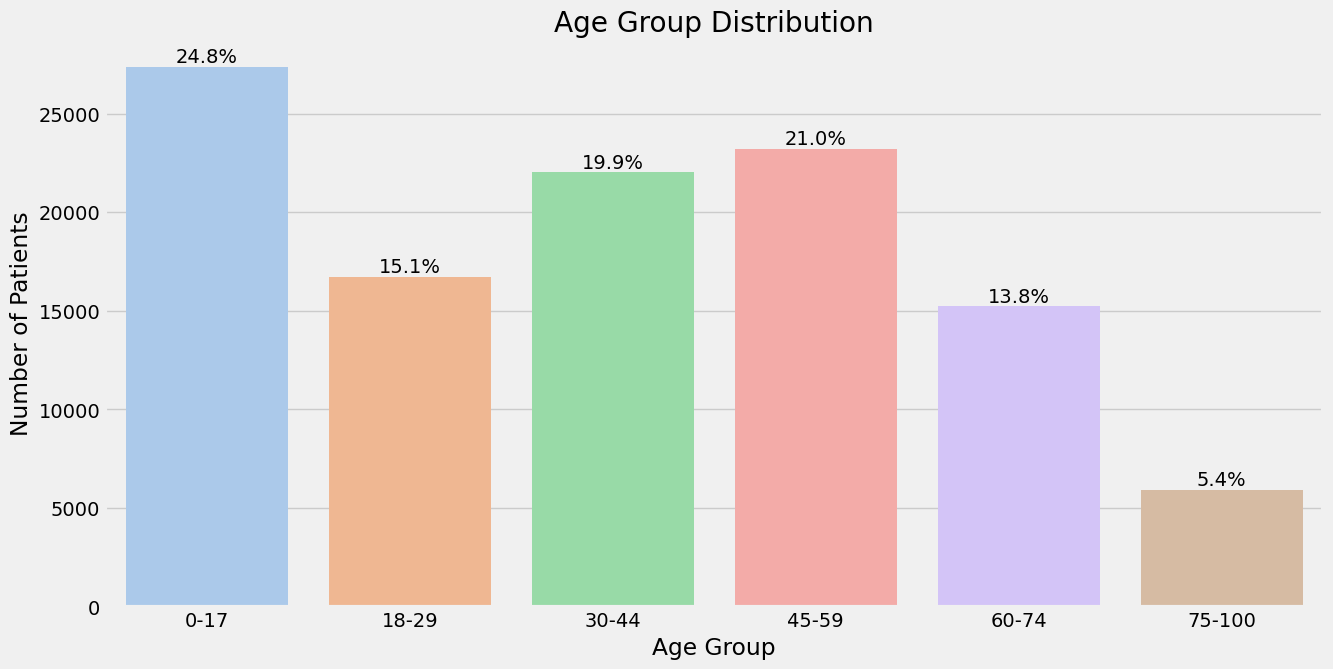

In [19]:
# Discretize the Age column into bins
age_bins = [0, 18, 30, 45, 60, 75, 100]
age_labels = ['0-17', '18-29', '30-44', '45-59', '60-74', '75-100']
age_group_df = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate age group counts and percentages
age_group_counts = age_group_df.value_counts().sort_index()
age_group_percentages = (age_group_counts / age_group_counts.sum()) * 100

# Prepare the data for plotting
plot_data = pd.DataFrame({'AgeGroup': age_group_counts.index, 'Count': age_group_counts.values, 'Percentage': age_group_percentages.values})

# Plot the bar chart
plt.figure(figsize=(14, 7))
sns.barplot(data=plot_data, x='AgeGroup', y='Count', palette='pastel', hue='AgeGroup', dodge=False)
plt.legend([],[], frameon=False)  # Hide the legend

# Add percentages on top of bars
for i, (count, percentage) in enumerate(zip(plot_data['Count'], plot_data['Percentage'])):
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.show()

In [20]:
show = df['no_show'] == 'No'
no_show = df['no_show'] == 'Yes'

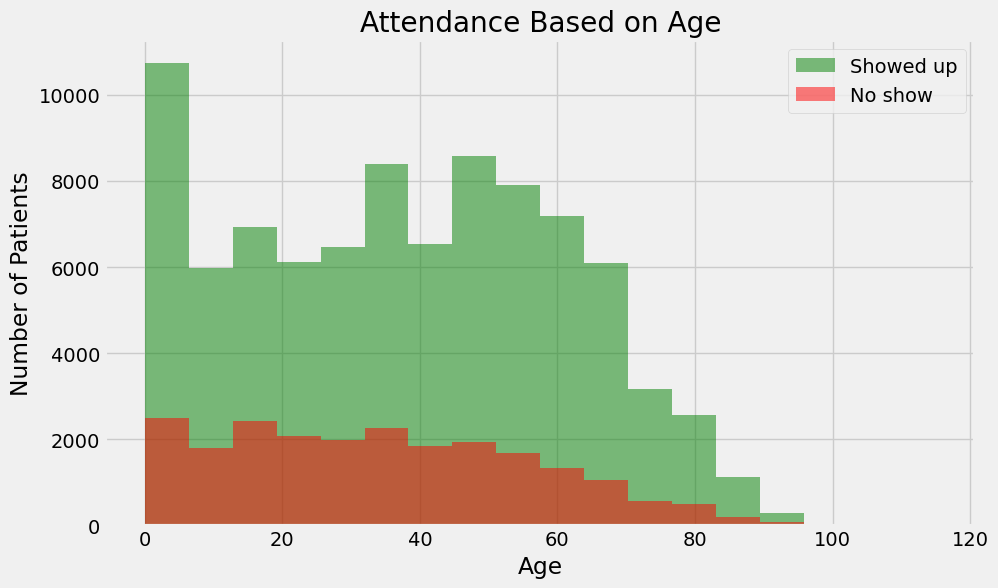

In [21]:
# Plot histograms for age based on attendance
plt.figure(figsize=(10, 6))

# Histogram for age of patients who showed up
plt.hist(df['age'][show], bins=18, color='green', alpha=0.5,  label='Showed up')
# Histogram for age of patients who didn't show up
plt.hist(df['age'][no_show], bins=18, alpha=0.5, color='red', label='No show')

plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.title('Attendance Based on Age')
plt.legend()

plt.show()

## Comparison of attendance between genders (Male and Female)

The analysis shows that 64.9% of females attended their appointments versus 35.1% of males, and 65.39% of females did not attend versus 34.61% of males. This indicates that while the dataset is skewed towards females, gender here is not a strong predictor of no-show behavior due to the similar percentage distributions across both attendance and no-shows. Consequently, to achieve the project's aim of improving attendance rates, it is crucial to explore other variables such as age, medical conditions, and the impact of SMS reminders, which may provide stronger correlations and insights into patient attendance patterns.

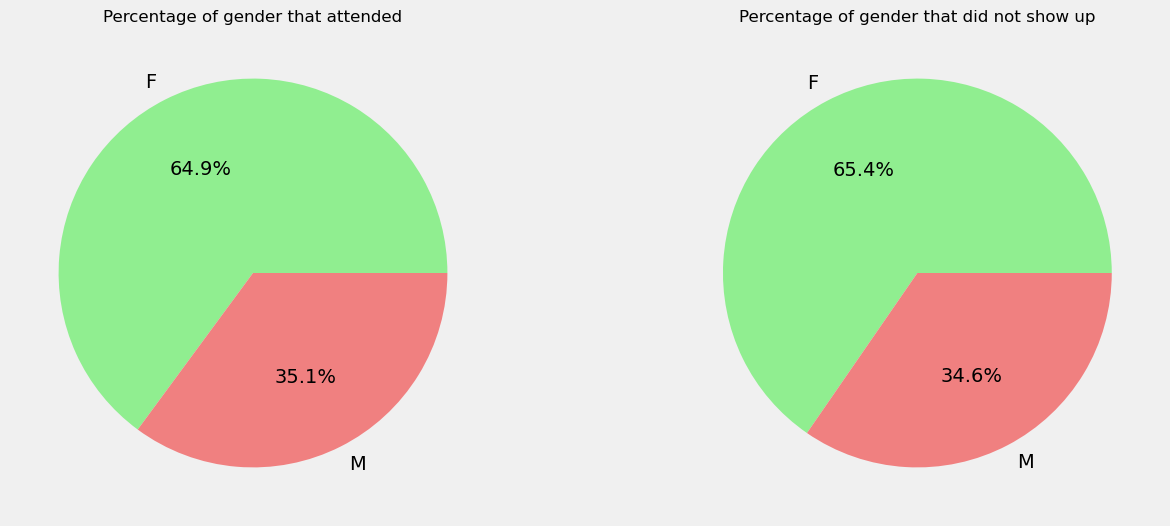

In [22]:



gender_showed = df[show]['gender'].value_counts(normalize=True)
gender_no_show = df[no_show]["gender"].value_counts(normalize=True)

colors = ['lightgreen', 'lightcoral']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
gender_showed.plot(kind='pie', autopct='%1.1f%%',ax=axes[0], colors=colors)        
axes[0].set_title('Percentage of gender that attended', fontdict={'fontsize':12})
axes[0].set_ylabel('')

gender_no_show.plot(kind='pie', autopct='%1.1f%%',ax=axes[1], colors=colors) 
axes[1].set_title('Percentage of gender that did not show up', fontdict={'fontsize': 12})
axes[1].set_ylabel('')

plt.show()       

## Comparison of attendance by chronic disease
(Note to self): Get reference for alcoholism definition as a chronic disease.
In exploring the correlation between chronic diseases and appointment attendance, our objective is to understand whether patients with chronic conditions may demonstrate distinct attendance patterns compared to those without such ailments. The analysis unveils a noticeable contrast in attendance rates, with 82.23% of patients with chronic diseases attending appointments versus 79.09% of those without. Conversely, 17.77% of patients with chronic diseases missed appointments, while 20.91% of those without chronic diseases did.

This disparity, a 3.14% difference in attendance rates, although may be thought of being relatively small, slightly suggests that ongoing health management may influence attendance behavior, providing insights for healthcare providers to tailor interventions and enhance appointment adherence across patient groups. However, the scale of this influence may not be determined yet as the data collection occured in a short time period. A longer time frame collection may yield better clarity in understanding this influence. But for the goal of the data exploration and modeling, chronic diseases such as hypertension, diabetes and alcoholism do not show a noteworthy correlation with appointment adherence.

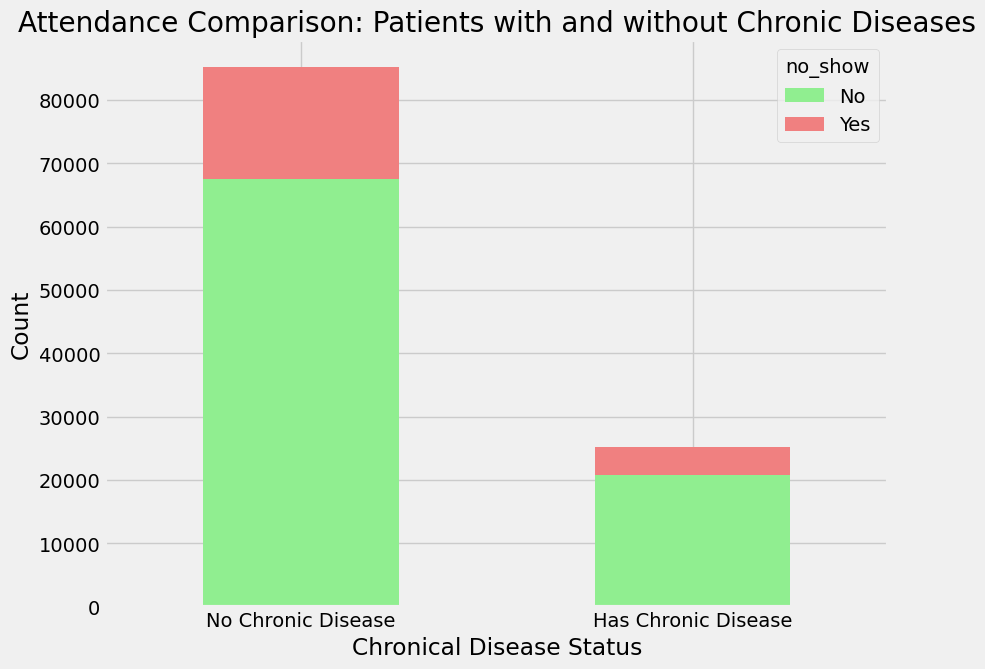

In [23]:
# Create a new column to indicate if a patient has any chronic disease
dfc = df.copy(deep=True)
dfc['has_chronic_disease'] = dfc[['hypertension', 'diabetes', 'alcoholism']].sum(axis=1) > 0

# Calculate the counts of no-shows and shows for patients with and without chronic diseases
comparison = dfc.groupby(['has_chronic_disease', 'no_show']).size().unstack().fillna(0)

# Plot the bar chart
ax = comparison.plot(kind='bar', stacked=True, color=['lightgreen', 'lightcoral'], figsize=(9, 7))

# Set labels and title
ax.set_xlabel('Chronical Disease Status')
ax.set_ylabel('Count')
ax.set_title('Attendance Comparison: Patients with and without Chronic Diseases')
ax.set_xticklabels(['No Chronic Disease', 'Has Chronic Disease'], rotation=0)


# Show the plot
plt.show()

In [24]:
# Calculate the counts of no-shows and shows for patients with and without chronic diseases
attendance_comparison = dfc.groupby(['has_chronic_disease', 'no_show']).size().unstack().fillna(0)

# Calculate percentages
attendance_percentages = attendance_comparison.div(attendance_comparison.sum(axis=1), axis=0) * 100

# Prepare data for printing as a table
table_data = [
    ["Chronic Disease", "No-show", "Show"],
    [False, attendance_comparison.loc[False, 'Yes'], attendance_comparison.loc[False, 'No']],
    [True, attendance_comparison.loc[True, 'Yes'], attendance_comparison.loc[True, 'No']],
]

# Print table headers
print("Counts of Attendance for Patients with and without Chronic Diseases:")
# Print table rows
for row in table_data:
    print("{:<17} | {:<7} | {:<5}".format(*row))

print("\nPercentages of Attendance for Patients with and without Chronic Diseases:")
# Print percentages
print(attendance_percentages.round(4))


Counts of Attendance for Patients with and without Chronic Diseases:
Chronic Disease   | No-show | Show 
0                 | 17838   | 67473
1                 | 4481    | 20734

Percentages of Attendance for Patients with and without Chronic Diseases:
no_show                   No      Yes
has_chronic_disease                  
False                79.0906  20.9094
True                 82.2288  17.7712


## Attendance comparison based on SMS received
In analyzing the correlation between SMS reception and appointment attendance, our aim is to discern whether patients who receive SMS reminders exhibit different attendance behavior compared to those who don't. The results reveal a notable difference in attendance rates: 83.30% of patients who did not receive an SMS reminder attended their appointments, while 16.70% did not. The discrepancy show that sending SMS reminders actually had an opposite outcome of the expectation that the reminders would improve attendance. However, we need to investigate how same-day appointments contributes to these findings.

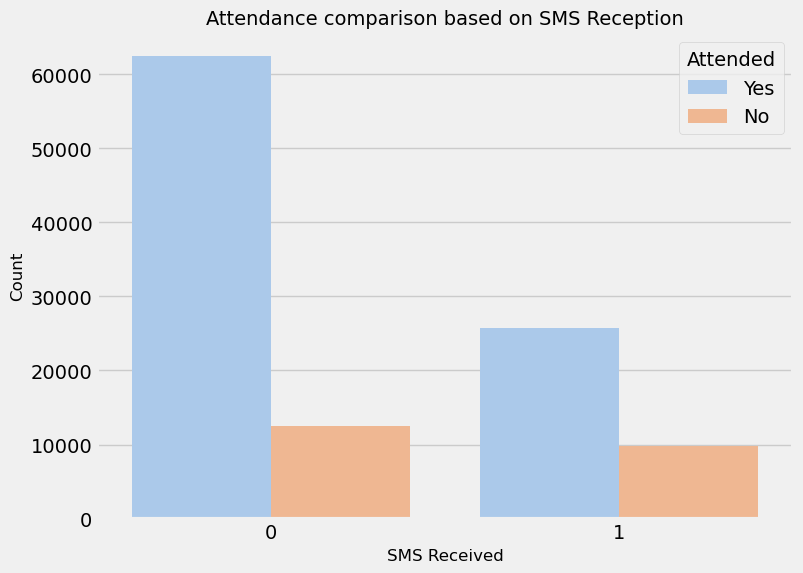

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sms_received', hue='no_show', data=df, palette='pastel')

# Set labels and title
plt.xlabel('SMS Received', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Attendance comparison based on SMS Reception', fontsize=14)

# Show plot
plt.legend(title='Attended', labels=['Yes', 'No'])
plt.show()

In [26]:
# Calculate the percentages of show and noshow instances for each category of SMS reception
perc_sms_show = df.groupby('sms_received')['no_show'].value_counts(normalize=True)[:, 'No'] * 100
perc_sms_noshow = df.groupby('sms_received')['no_show'].value_counts(normalize=True)[:, 'Yes'] * 100

# Prepare data for printing as a table
table_data = []
for sms_received, show_percentage, noshow_percentage in zip(perc_sms_show.index, perc_sms_show.values, perc_sms_noshow.values):
    table_data.append([sms_received, show_percentage, noshow_percentage])

# Print table headers
print("SMS Received | Show Percentage | Noshow Percentage")
# Print table rows
for row in table_data:
    print("{:<12} | {:<15.2f}% | {:<15.2f}%".format(*row))


SMS Received | Show Percentage | Noshow Percentage
0            | 83.30          % | 16.70          %
1            | 72.43          % | 27.57          %


## Same day appointments statistics
Roughly 35% of all appointments recorded were same-day appointments. This distribution is significant enough to influence the results gathered earlier. Therefore, it is necessary to filter out same-day appointments as this will be the real test of the impact of the sms campaign.

In [27]:
is_same_day = (df['scheduled_day'].dt.date == df['appointment_day'].dt.date) & (df['scheduled_day'].dt.month == df['appointment_day'].dt.month)
same_day_appts = df[is_same_day == True]
same_day_appts_count = same_day_appts.value_counts().sum()
# Non-same day appointments
not_same_day_appts = df[is_same_day == False]

print(f"Number of appointments scheduled on the same day: {same_day_appts_count}")
print(f"Percentage of appointments scheduled on the same day: {(same_day_appts_count / df.shape[0]) * 100:.4f}%")

Number of appointments scheduled on the same day: 38562
Percentage of appointments scheduled on the same day: 34.8895%


In [28]:
not_same_day_appts_count = not_same_day_appts.value_counts().sum()
print(f"Number of appointments scheduled on different days: {not_same_day_appts_count}")
not_same_day_appts.shape

Number of appointments scheduled on different days: 71964


(71964, 13)

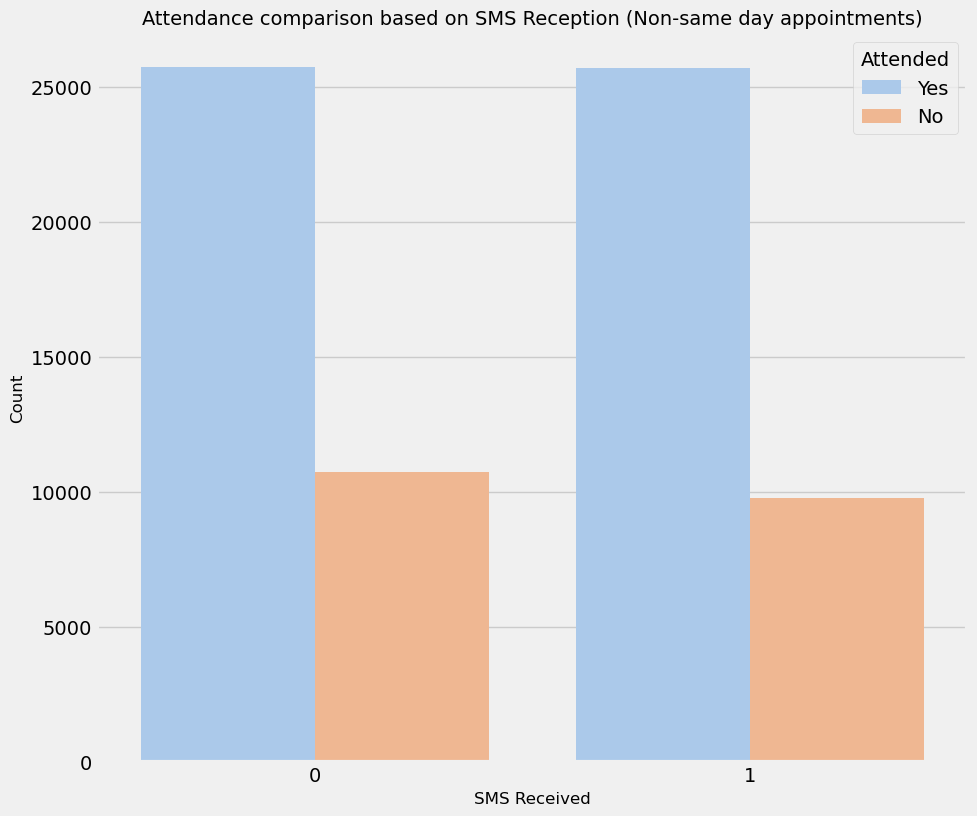

In [29]:
plt.figure(figsize=(10, 9))
sns.countplot(x='sms_received', hue='no_show', data=not_same_day_appts, palette='pastel')

# Set labels and title
plt.xlabel('SMS Received', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Attendance comparison based on SMS Reception (Non-same day appointments)', fontsize=14)

# Show plot
plt.legend(title='Attended', labels=['Yes', 'No'])
plt.show()

After filtering out same-day appointments, the new analysis revealed that patients who did not receive an SMS had a show percentage of 70.55% and a no-show percentage of 29.45%. Those who received an SMS showed a slight increase in attendance, with a show percentage of 72.43% and a no-show percentage of 27.57%. This suggests that, for non-same-day appointments, receiving an SMS has a modest positive impact on attendance, improving the show rate by approximately 2% compared to those who did not receive an SMS.

In [30]:
# Calculate the percentages of show and noshow instances for each category of SMS reception for non-same day appointments
perc_sms_show = not_same_day_appts.groupby('sms_received')['no_show'].value_counts(normalize=True)[:, 'No'] * 100
perc_sms_noshow = not_same_day_appts.groupby('sms_received')['no_show'].value_counts(normalize=True)[:, 'Yes'] * 100

# Prepare data for printing as a table
table_data = []
for sms_received, show_percentage, noshow_percentage in zip(perc_sms_show.index, perc_sms_show.values, perc_sms_noshow.values):
    table_data.append([sms_received, show_percentage, noshow_percentage])

# Print table headers
print("SMS Received | Show Percentage | Noshow Percentage")
# Print table rows
for row in table_data:
    print("{:<12} | {:<15.4f}% | {:<15.4f}%".format(*row))


SMS Received | Show Percentage | Noshow Percentage
0            | 70.5526        % | 29.4474        %
1            | 72.4255        % | 27.5745        %


## Attendance comparison by Handicap

Based on the analysis of attendance comparison based on the level of handicap, we observe varying trends. The majority of appointments involve patients with no reported handicap, comprising approximately 97.97% of the dataset. Among these appointments, the no-show rate is 20.24%, indicating a moderate but notable proportion of missed appointments. Interestingly, appointments involving patients with a reported handicap level of 1 or 2 exhibit slightly lower no-show rates compared to those with no reported handicap, suggesting a potential correlation between a mild level of handicap and increased appointment attendance. However, caution is warranted in interpreting these findings due to the relatively small sample sizes of patients with higher levels of handicap (levels 3 and 4), which may not be representative. Further investigation with larger datasets or stratified analyses by handicap severity may provide deeper insights into the relationship between handicap level and appointment attendance.

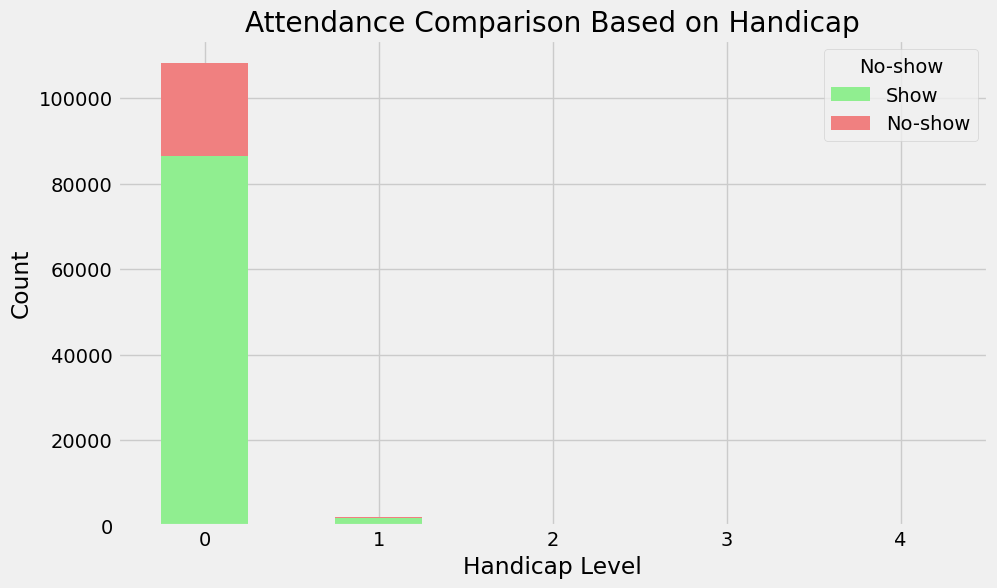

In [31]:
# Calculate the counts for show and no-show for each handicap level
handicap_attendance_counts = df.groupby(['handicap', 'no_show']).size().unstack().fillna(0)

# Plot the bar chart
handicap_attendance_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightgreen', 'lightcoral'])

# Add labels and title
plt.xlabel('Handicap Level')
plt.ylabel('Count')
plt.title('Attendance Comparison Based on Handicap')
plt.legend(title='No-show', loc='upper right', labels=['Show', 'No-show'])
plt.xticks(rotation=0)

plt.show()

In [32]:
# Calculate the total count per handicap level
handicap_total_counts = df.groupby('handicap').size()


handicap_attendance_counts = df.groupby(['handicap', 'no_show']).size().unstack().fillna(0)

handicap_attendance_percentages = handicap_attendance_counts.div(handicap_total_counts, axis=0) * 100

handicap_summary = pd.DataFrame({
    'Handicap Level': handicap_total_counts.index,
    'Total Count': handicap_total_counts.values,
    'Show Count': handicap_attendance_counts['No'].values,
    'Noshow Count': handicap_attendance_counts['Yes'].values,
    'Show Percentage': handicap_attendance_percentages['No'].values,
    'Noshow Percentage': handicap_attendance_percentages['Yes'].values
})

# Print the summary table
print(handicap_summary.to_string(index=False))


 Handicap Level  Total Count  Show Count  Noshow Count  Show Percentage  Noshow Percentage
              0       108285       86373         21912        79.764510          20.235490
              1         2042        1676           366        82.076396          17.923604
              2          183         146            37        79.781421          20.218579
              3           13          10             3        76.923077          23.076923
              4            3           2             1        66.666667          33.333333


## Attendance Comparison based on Scholarship status

We observe that the majority of patients without scholarship status attended their appointments, with an attendance rate of 80.19%. Conversely, patients with scholarship status had a slightly lower attendance rate of 76.26%.

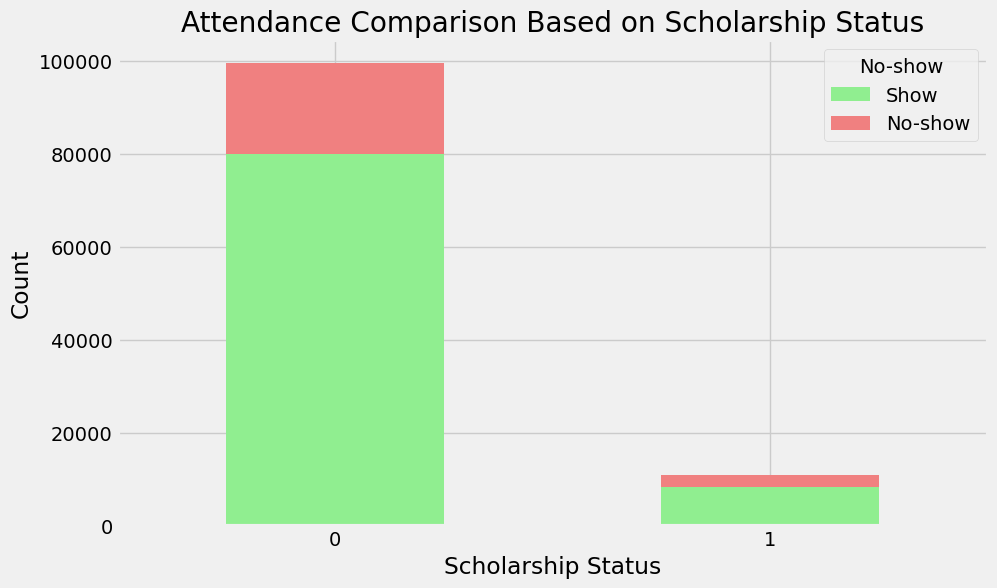

no_show,No,Yes
scholarship,,
0,79924,19741
1,8283,2578


In [33]:
# Calculate the counts for show and no-show for each scholarship status
scholarship_attendance_counts = df.groupby(['scholarship', 'no_show']).size().unstack()

# Plot the bar chart
scholarship_attendance_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightgreen', 'lightcoral'])

# Add labels and title
plt.xlabel('Scholarship Status')
plt.ylabel('Count')
plt.title('Attendance Comparison Based on Scholarship Status')
plt.legend(title='No-show', loc='upper right', labels=['Show', 'No-show'])
plt.xticks(rotation=0)

plt.show()
# #does neighbourhood affect the attendance?
# plt.figure(figsize=(20,13))
# df['scholarship'][show].value_counts().plot(kind='bar', color = 'blue', label = 'show')
# df['scholarship'][no_show].value_counts().plot(kind='bar', color = 'red', label = 'noShow')
# plt.legend()
# plt.title('comparison according to Neighbourhood')
# plt.xlabel('Neighbourhood')
# plt.ylabel('Patient No.')

scholarship_attendance_counts.head()

In [34]:
print(df.groupby('scholarship').size().sum())
df.groupby('scholarship')

110526


In [35]:
# Calculate the total count per scholarship status
scholarship_total_counts = df.groupby('scholarship').size()
scholarship_attendance_perc = scholarship_attendance_counts.div(scholarship_total_counts, axis=0) * 100

scholarship_summary = pd.DataFrame({
    'Scholarship Status': scholarship_total_counts.index,
    'Total Count': scholarship_total_counts.values,
    'Show Count': scholarship_attendance_counts['No'].values,
    'Noshow Count': scholarship_attendance_counts['Yes'].values,
    'Show Percentage': scholarship_attendance_perc['No'].values,
    'Noshow Percentage': scholarship_attendance_perc['Yes'].values
})

print(scholarship_summary.to_string(index=False))

 Scholarship Status  Total Count  Show Count  Noshow Count  Show Percentage  Noshow Percentage
                  0        99665       79924         19741        80.192645          19.807355
                  1        10861        8283          2578        76.263696          23.736304


## Attendance comparison based on Neighborhood

The variability in the percentages of attendance per neighbourhood shows neighbourhood has a strong effect on attendance, perhaps more than other features explored in this analysis. This may be the factor that contributes most to attendance and this might need to be investigated further, although that is beyond the scope of the data analysis.

Text(0, 0.5, 'Patient No.')

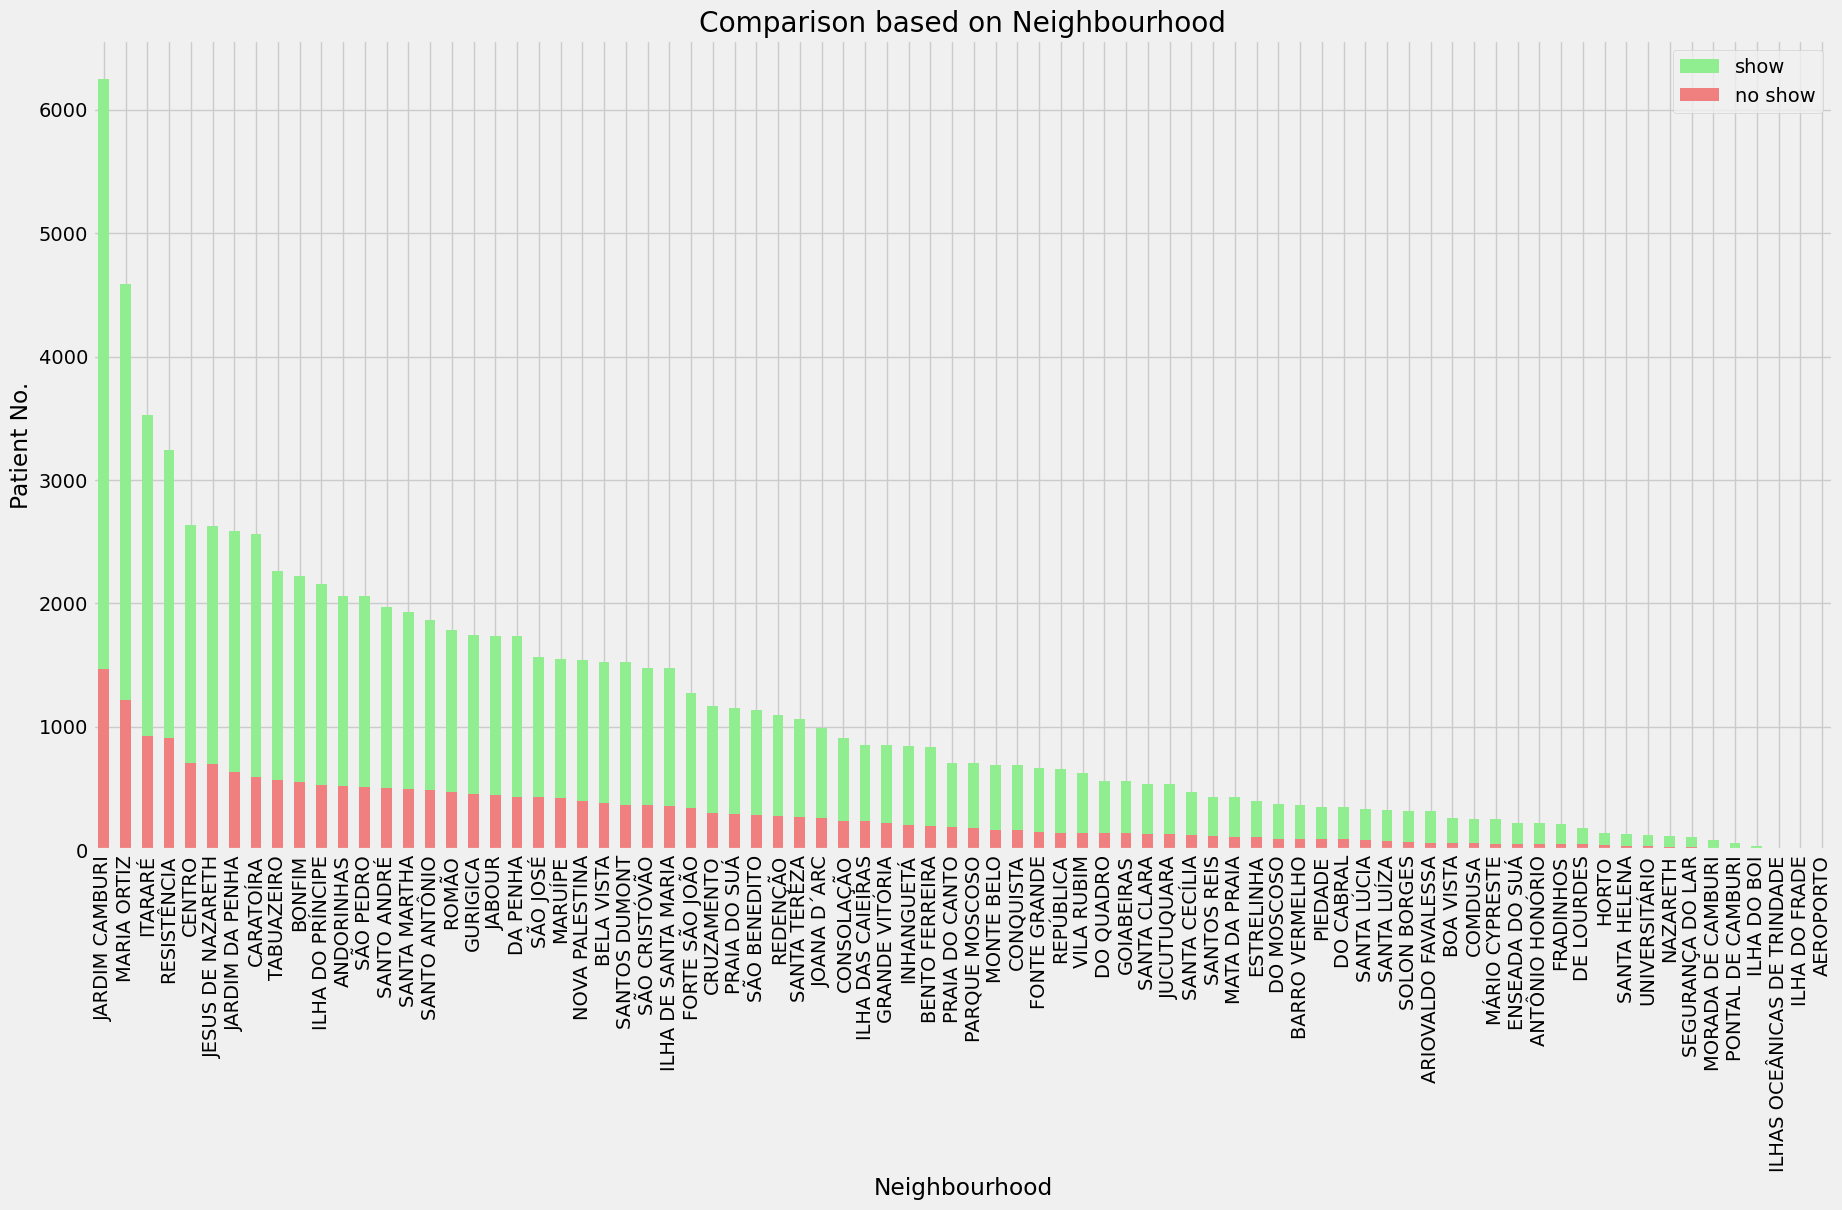

In [36]:
#does neighbourhood affect the attendance?
plt.figure(figsize=(20,10))
df['neighbourhood'][show].value_counts().plot(kind='bar', color = 'lightgreen', label = 'show')
df['neighbourhood'][no_show].value_counts().plot(kind='bar', color = 'lightcoral', label = 'no show')
plt.legend()
plt.title('Comparison based on Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Patient No.')

In [37]:
# Group by neighborhood and no_show, calculate counts
neighborhood_counts = df.groupby(['neighbourhood', 'no_show']).size().unstack().fillna(0)

# Calculate total count per neighborhood
total_counts = neighborhood_counts.sum(axis=1)

# Sort neighborhoods by total count in descending order
sorted_neighborhood_counts = neighborhood_counts.loc[total_counts.sort_values(ascending=False).index]

# Calculate percentages
neighborhood_percentages = (sorted_neighborhood_counts.div(sorted_neighborhood_counts.sum(axis=1), axis=0) * 100).round(2)

# Prepare the data for printing
data = {
    'Neighborhood': sorted_neighborhood_counts.index,
    'Total Count': sorted_neighborhood_counts.sum(axis=1),
    'Show Count': sorted_neighborhood_counts['No'],
    'Noshow Count': sorted_neighborhood_counts['Yes'],
    'Show Percentage': neighborhood_percentages['No'],
    'Noshow Percentage': neighborhood_percentages['Yes']
}

# Create DataFrame
result_df = pd.DataFrame(data)

# Print the table
print(result_df.head(15).to_string(index=False))


     Neighborhood  Total Count  Show Count  Noshow Count  Show Percentage  Noshow Percentage
   JARDIM CAMBURI       7717.0      6252.0        1465.0            81.02              18.98
      MARIA ORTIZ       5805.0      4586.0        1219.0            79.00              21.00
      RESISTÊNCIA       4431.0      3525.0         906.0            79.55              20.45
  JARDIM DA PENHA       3877.0      3246.0         631.0            83.72              16.28
          ITARARÉ       3514.0      2591.0         923.0            73.73              26.27
           CENTRO       3334.0      2631.0         703.0            78.91              21.09
       TABUAZEIRO       3132.0      2559.0         573.0            81.70              18.30
     SANTA MARTHA       3131.0      2635.0         496.0            84.16              15.84
JESUS DE NAZARETH       2853.0      2157.0         696.0            75.60              24.40
           BONFIM       2773.0      2223.0         550.0            80

## Class Imbalance Investigation
There is a significant imbalance between the classes as over 88k patients attended their appointments versus over 22k missing their appointments. A similar imbalance still appears even after filtering out same-day appointments as it was already known that 35% of the appointments were same-day appointments which majorly were shows (No in no_show class). This occurence must be considered during data modeling. This also means the metric for model quality may not be accuracy and might be other metrics like F1 Score and ROC AUC. Another possible technique that can be implemented could be Random Undersampling.

In [38]:
df['no_show'].value_counts()

no_show
No     88207
Yes    22319
Name: count, dtype: int64

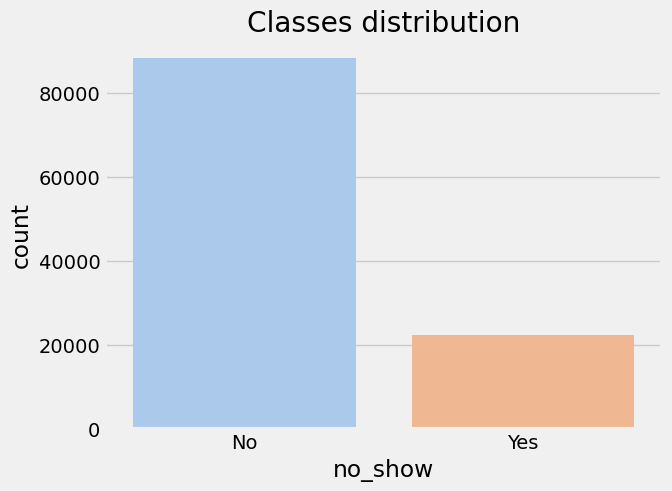

In [39]:
# Investigate the class imbalance in the dataset (no-shows vs shows) and plot the distribution on one bar chart

sns.countplot(x='no_show', data=df, palette='pastel')
plt.title("Classes distribution")
plt.show()



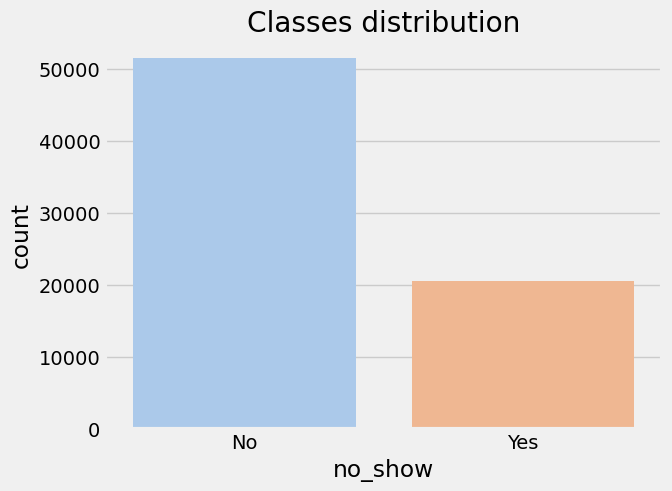

In [40]:
# Check class imbalance if same day appointments are removed  and plot the distribution on one bar chart
sns.countplot(x='no_show', data=not_same_day_appts, palette='pastel')
plt.title("Classes distribution")
plt.show()

In [41]:

# Ratio of shows to no-shows
no_show_ratio = df['no_show'].value_counts(normalize=True)['Yes'] / df['no_show'].value_counts(normalize=True)['No']
no_show_ratio = round(no_show_ratio, 2)
print(f'Ratio of shows to no-shows: {no_show_ratio.as_integer_ratio()[1]}:{no_show_ratio.as_integer_ratio()[0]}')

Ratio of shows to no-shows: 4:1


# Data Modelling
As we proceed with the data modeling stage, two data modeling techniques were chosen for predicting if a patient will miss their appointments or not. The model techniques used are:
1. Logistic Regression Classifier
2. Neural Network Classifier

## 1. Convert categorical features to numerical

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
dfm = df.copy(deep=True)
dfm.shape

(110526, 13)

In [44]:
# Drop rows where the values of the handicap column are greater than 1
print(dfm[dfm['handicap'] > 1].value_counts().sum())
dfm.drop(dfm[dfm['handicap'] > 1].index, inplace=True)
dfm.reset_index(drop=True, inplace=True)
dfm.shape

199


(110327, 13)

In [45]:
# Create Male and Female numerical columns from gender column
dfm['is_male'] = dfm['gender'].map({'M': 1, 'F': 0})

# Convert the target variable column
dfm['no_show'] = dfm['no_show'].map({'Yes': 1, 'No': 0})

# Drop the gender column
dfm.drop(columns=['gender'], inplace=True, axis=1)
print(dfm.tail())
dfm.shape


          patient_id             scheduled_day           appointment_day  age neighbourhood  scholarship  hypertension  diabetes  alcoholism  handicap  sms_received  no_show  is_male
110322  2.572134e+12 2016-05-03 09:15:35+00:00 2016-06-07 00:00:00+00:00   56   MARIA ORTIZ            0             0         0           0         0             1        0        0
110323  3.596266e+12 2016-05-03 07:27:33+00:00 2016-06-07 00:00:00+00:00   51   MARIA ORTIZ            0             0         0           0         0             1        0        0
110324  1.557663e+13 2016-04-27 16:03:52+00:00 2016-06-07 00:00:00+00:00   21   MARIA ORTIZ            0             0         0           0         0             1        0        0
110325  9.213493e+13 2016-04-27 15:09:23+00:00 2016-06-07 00:00:00+00:00   38   MARIA ORTIZ            0             0         0           0         0             1        0        0
110326  3.775115e+14 2016-04-27 13:30:56+00:00 2016-06-07 00:00:00+00:00   54   MARIA

(110327, 13)

In [46]:
dfm.head()

,patient_id,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,is_male
0,2.987250e+13,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,5.589978e+14,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,1
2,4.262962e+12,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,8.679512e+11,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8.841186e+12,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0


## Model Design Thought Process

## Knowledge Summary
This is what we know from the dataset.
1. The target variable is significantly imbalanced with more patients attending vs no shows.
2. The dataset has a mix of categorical and numerical features. But we have converted the categorical features to numerical.
3. The dataset has no missing or duplicate values.
4. We have used frequency encoding for the neighbourhood column which is a high cardinality column.
5. We have normalized the age column.
6. We have evaluated the correlations between the features and the target variable using the Chi-Square test and the Pearson correlation coefficient.
7. From the correlation tests, we can see the top 5 features that are most related to the target variable are: sms_received, hypertension, scholarship, neighbourhood_encoded, and age_scaled.

## Next Steps
1. We will split the dataset into training, validation, and test sets. We will use 70% of the data for training, 15% for validation, and 15% for testing
2. We will need to handle the class imbalance in the training set by using Random undersampling.
3. We will use a Random Forest Classifier to build the model.
4. We will evaluate the model using the validation set.
5. We will fine-tune the model using GridSearchCV.
6. We will evaluate the model using the test set.

### We have neighbourhood column with high cardinality. Using one-hot encoding will increase the number of columns significantly. Therefore, we can use frequency encoding to encode the neighbourhood column.

## Feature Selection

Before modeling, we need to select what features may contribute the most information gain to the model, i.e correlates with the target variables. From the dataset, most of the features are binary, including the target variables. For categorical input features with categorical output/target, a well-known method for determining the correlation is called Chi-Square Test. However, we have converted the neighbourhood and age features to non-binary numerical features. For these columns, we may need to apply a different correlation discovery technique called Pearson Correlation Coefficient.

## Chi Square 
I will select the best 3 features with the highest importance from the results of conducting the Chi Square. This works by choosing the three features with the highest chi values and lowest p values.

# Pearson Correlation Coefficient
As there are only 2 input features,adding to the previously selected 3 features from the Chi-Square test gives 5 features which is not too much for the model. So after visualization, we can add both features as inputs for the models and evaluate the performance.

In [47]:
from sklearn.feature_selection import chi2

In [48]:
dfm.columns

Index(['patient_id', 'scheduled_day', 'appointment_day', 'age', 'neighbourhood', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show', 'is_male'], dtype='object')

In [49]:
X = dfm.drop(columns=['no_show', 'patient_id', 'scheduled_day', 'appointment_day', 'neighbourhood','age'], axis=1)
y = dfm['no_show']

In [50]:
chi_scores = chi2(X, y)

In [51]:
chi_values = pd.Series(chi_scores[0], index=X.columns)
chi_values.sort_values(ascending=False, inplace=True)


In [52]:
# Higher the p-value, the more the feature is independent of the target variable

p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending=False, inplace=True)


In [53]:
# Print Chi and P-values for each feature
print("Chi and P-values for each feature:")
# Print the table
print(pd.concat([chi_values, p_values], axis=1, keys=['Chi', 'P-value']))

Chi and P-values for each feature:
                      Chi        P-value
sms_received  1201.819490  2.453994e-263
hypertension   115.964673   4.838390e-27
scholarship     85.934863   1.859612e-20
diabetes        23.569397   1.204887e-06
handicap         6.524156   1.064191e-02
is_male          1.128373   2.881227e-01
alcoholism       0.006400   9.362389e-01


Text(0.5, 1.0, 'Chi value importance for each feature')

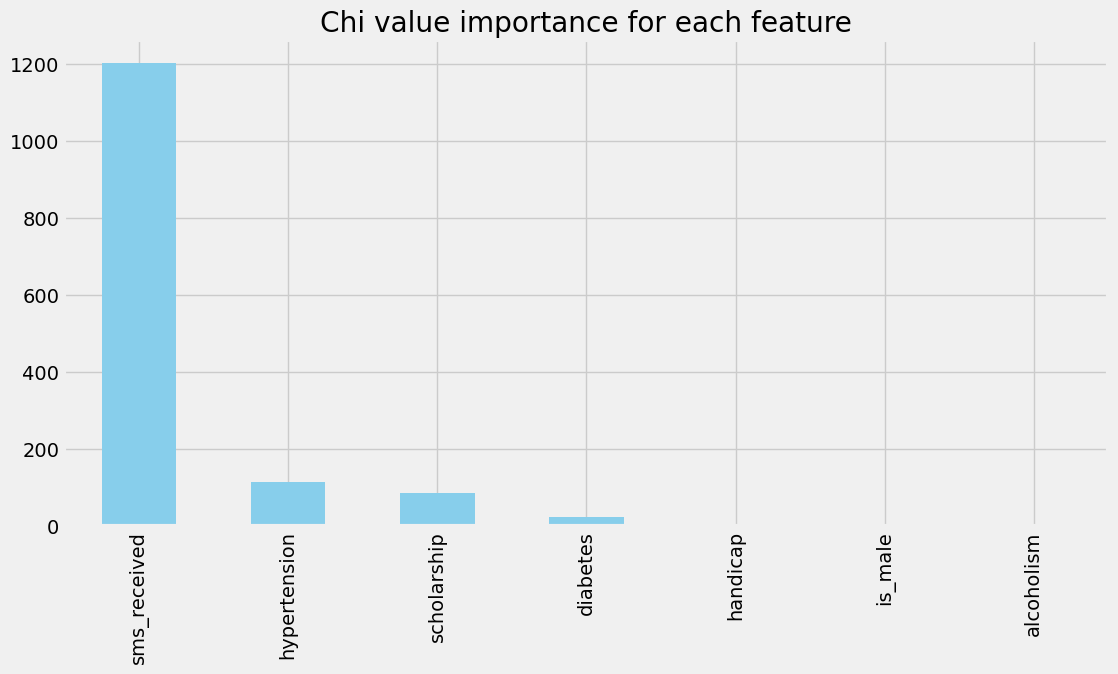

In [54]:
# Higher the chi-squared value, the more the feature is related to the target variable
# Plot the chi-squared values using a bar chart. Give a chart title of 'Chi value importance for each feature'
chi_values.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Chi value importance for each feature')

Text(0.5, 1.0, 'P-value importance for each feature')

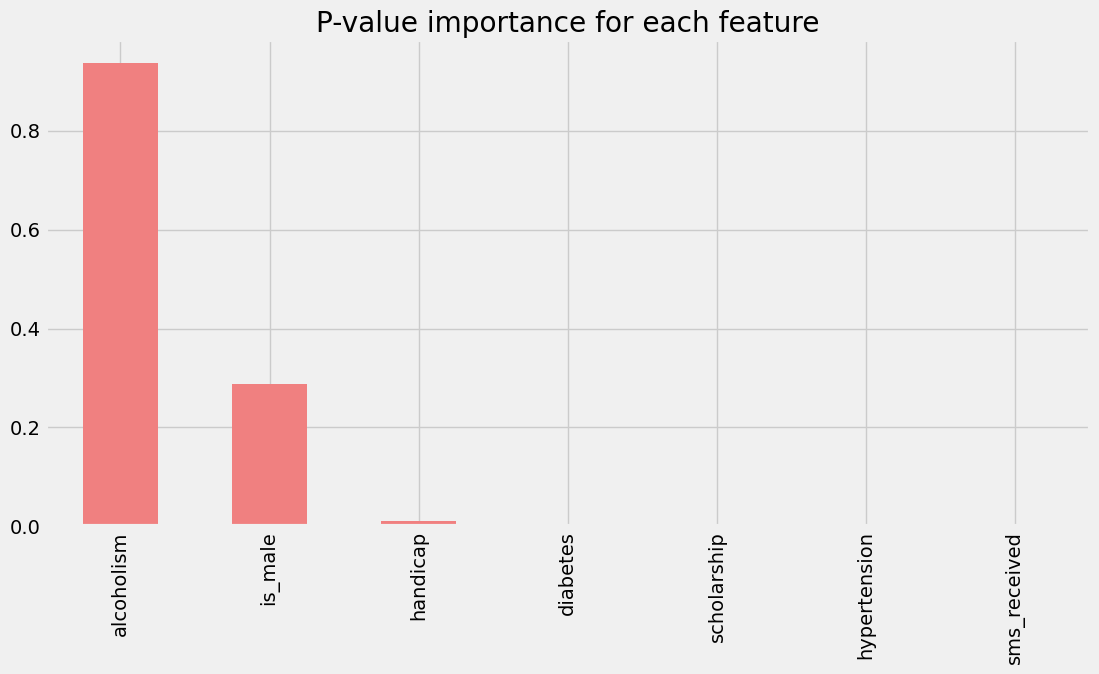

In [55]:
# Plot the p-values using a bar chart. Give a chart title of 'P-value importance for each feature'
p_values.plot(kind='bar', figsize=(12, 6), color='lightcoral')
plt.title('P-value importance for each feature')

In [57]:
# Perform frequency encoding on the neighbourhood column in a new column named 'neighbourhood_freq'
neighbourhood_freq = dfm['neighbourhood'].value_counts(normalize=True)
dfm['neighbourhood_freq'] = dfm['neighbourhood'].map(neighbourhood_freq)

# Perform min max scaling on the age column in a new column named 'age_scaled'
scaler = MinMaxScaler()
dfm['age_scaled'] = scaler.fit_transform(dfm[['age']])



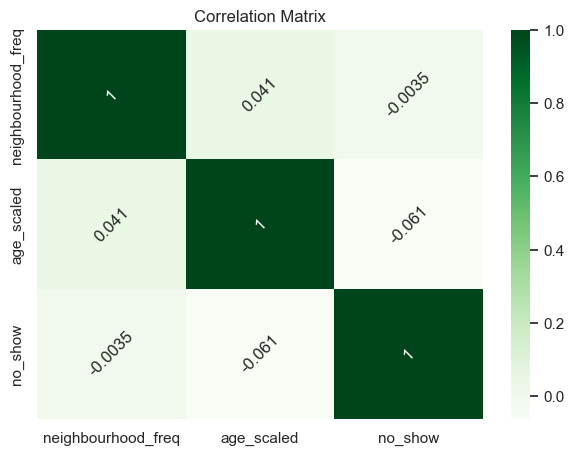

In [58]:
sns.set_theme(style="white")
non_binary_cols = ['neighbourhood_freq', 'age_scaled', 'no_show']
corr = dfm[non_binary_cols].corr()  # Create the pearson correlation metrix object

fig, ax = plt.subplots() # create the figure

sns.heatmap(corr, annot=True, cmap='Greens', annot_kws={'rotation':45}) # Draw the heatmap

plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Split the data into training and testing sets
from sklearn.linear_model import LogisticRegression
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
from utility.utils import preprocessing_pipeline, split_encode_scale_pipeline

X_train, y_train, X_test, y_test = split_encode_scale_pipeline(df=dfm, target_col_label='no_show', selected_cols=['age', 'scholarship', 'hypertension', 'sms_received', 'neighbourhood'])

In [ ]:
from utility.utils import cross_val_report

# Stratified K-Fold Cross Validation on Training Set With Logistic Regression and Random Forest

This stage involved the validation of the base models of Logistic Regression and Random Forest Classifier. These models are widely used in classification problems and compatible with the dataset for this project.

This was implemented via cross_val_score from the sklearn library with a stratified K-Fold of 5 number of splits with shuffling set to true. This enables validating of the models on the training consistently as a simple train, validation, test split may generate inconsistent metrics depending on the split distribution per turn.

In [ ]:

# Logistic Regression Cross Validation Report (Stratified K-Fold: 5) (Random Under Sampling strategy: not minority)

lr_cls_report, lr_conf_matrix, avg_roc_auc = cross_val_report(X=X_train, y=y_train, model=LogisticRegression(random_state=42), target_names=['Show', 'No-show'], model_name='Logistic Regression')

In [ ]:
# Random Forest Classifier Cross Validation Report (Stratified K-Fold: 5)

rf_cls_report, rf_conf_matrix, avg_roc_auc = cross_val_report(X=X_train, y=y_train, model=RandomForestClassifier(random_state=1), target_names=['Show', 'No-show'], model_name='Random Forest Classifier')

**Hyperparameter Tuning with GridSearchCV**

The base logistic regression and random forest models performed poorly especially on metrics for the positive class (No Shows 1). Base Random Forest Classifier performed the worst out of the two, in predicting patient's not showing up which is the main concern for the project. However, we can use GridSearchCV, a method provided by the scikit-learn library that exhaustively runs the base models using all possible combinations of a parameter grid to perform validation. The best model is returned with the optimal hyperparameters.
To perform hyperparameter tuning, I will:
1. Define the hyperparameters to tune for each model
2. Use the training set for 
3. Run GridSearchCV cross-validation for each model on the training set with a K-fold of 5 and store the optimal parameters.
4. Store the optimal parameters and their respective scores. These will be determined using multi-metric scoring based on f1-score, roc auc, and accuracy.

Optimal Parameters and Scores for each model:
lr:
Optimal Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Score: 0.5962295522051984

rf:
Optimal Parameters: {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Score: 0.5905073703760599

In [ ]:
# Define the hyperparameters to tune
tuning_grid = {
    'lr':{
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.001, 1, 10],
            'max_iter': [1000, 1500],
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2']
        }
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [40, 50],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4]
        }
    }
}

With GridSearchCV, it is observed that the best parameters found for the models still yields a poor ROC_AUC score. Therefore even with hyperparameter tuning, the models do not generalize or predict the positive class well.

Optimal Parameters and Scores for each model:
Logistic Regression:
Optimal Parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Score: 0.5955464221008817
Random Forest:
Optimal Parameters: {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Score: 0.5888504250473339



In [ ]:
from utility.utils import grid_search_cv_tuning

In [ ]:




# Perform hyperparameter tuning
results, optim_params = grid_search_cv_tuning(X_train, y_train, tuning_grid)

Feature engineering is another way of improving the performance of machine learning models, particularly when initial attempts with other methods have not yielded significant improvements. Below are some proposed new features that could potentially enhance the model's ability to predict no-shows:

### Proposed New Features

1. **Days Between Scheduling and Appointment**
   - **Reason**: The time gap between when an appointment is scheduled and when it is actually held could influence the likelihood of a no-show. Longer gaps may lead to more no-shows due to changes in patients' schedules or forgotten appointments.
2. **Previous No-Shows**
   - **Reason**: Patients with a history of no-shows are more likely to miss future appointments. This feature can capture the no-show behavior of patients.


In [ ]:
# 1. Create new column for the days between scheduled and appointment days

dfm['days_between'] = (dfm['appointment_day'] - dfm['scheduled_day']).dt.days

dfm['days_between'].unique()

**Handle rows where days_between is negative as appointment day cannot come before the scheduled day.**

In [ ]:
dfm.query("days_between < 0")

**There are a lot of negatives. After inspecting, we can see that the scheduled_day has the time included while the appointment day doesnt. This leads to the scheduled_day being ahead by time. This can be resolved by removing time from the scheduled day.**

In [ ]:
# Remove the time part of the scheduled_day column
dfm['scheduled_day'] = dfm['scheduled_day'].dt.normalize()
dfm['days_between'] = (dfm['appointment_day'] - dfm['scheduled_day']).dt.days
dfm.query("days_between < 0")

In [ ]:
# Drop rows where the days_between column is negative
dfm.drop(dfm[dfm['days_between'] < 0].index, inplace=True)
dfm.reset_index(drop=True, inplace=True)

In [ ]:
# Create a new column to indicate if a patient has missed a previous appointment
# dfm['previous_no_show'] = dfm.groupby('patient_id')['no_show'].shift(1).fillna(0).astype(int)
dfm['previous_no_shows'] = dfm.groupby('patient_id')['no_show'].transform('sum')



In [ ]:
# Check pearson correlation for the new features via plotting a heatmap
sns.set_theme(style="white")
non_binary_cols = ['days_between', 'previous_no_shows', 'no_show', 'age']
corr = dfm[non_binary_cols].corr()  # Create the pearson correlation metrix object

fig, ax = plt.subplots() # create the figure

sns.heatmap(corr, annot=True, cmap='Greens', annot_kws={'rotation':45}) # Draw the heatmap

plt.title("Correlation Matrix")
plt.show()

**Predict target variable given new features**

This stage involves predicting the classes using the new features added to the dataframe. From the results, a significant improvement was observed after a 5-fold cross validation.
Both models were able to predict No-shows significantly better. This shows a clear positive impact of the derived features via feature engineering. One can attempt to improve this performance even further as although the f1-score for the No show improved for both models, through a round of hyper parameter tuning, the models might improve even more in these metrics.

Logistic Regression Confusion Matrix:
          Show  No-show
Show     59375    11064
No-show   2793    15025
Logistic Regression Classification Report:
              precision    recall  f1-score   support

        Show       0.96      0.84      0.90     70439
     No-show       0.58      0.84      0.68     17818

    accuracy                           0.84     88257
   macro avg       0.77      0.84      0.79     88257
weighted avg       0.88      0.84      0.85     88257

Logistic Regression Average ROC AUC Score: 0.9065

Random Forest Classifier Confusion Matrix:
          Show  No-show
Show     59175    11264
No-show   1126    16692
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

        Show       0.98      0.84      0.91     70439
     No-show       0.60      0.94      0.73     17818

    accuracy                           0.86     88257
   macro avg       0.79      0.89      0.82     88257
weighted avg       0.90      0.86      0.87     88257

Random Forest Classifier Average ROC AUC Score: 0.9289

In [ ]:
X_train, y_train, X_test, y_test = split_encode_scale_pipeline(df=dfm, target_col_label='no_show', selected_cols=['age', 'scholarship', 'hypertension', 'sms_received', 'neighbourhood', 'days_between', 'previous_no_shows'])

In [ ]:
# Logistic Regression Cross Validation Report (Stratified K-Fold: 5) (Random Under Sampling strategy: not minority)

lr_cls_report, lr_conf_matrix, avg_roc_auc = cross_val_report(X=X_train, y=y_train, model=LogisticRegression(random_state=42), target_names=['Show', 'No-show'], model_name='Logistic Regression')

In [ ]:
# Random Forest Classifier Cross Validation Report (Stratified K-Fold: 5)

rf_cls_report, rf_conf_matrix, avg_roc_auc = cross_val_report(X=X_train, y=y_train, model=RandomForestClassifier(random_state=1), target_names=['Show', 'No-show'], model_name='Random Forest Classifier')

**Hyper parameter Tuning Using GridSearchCV and Derived Features**

The results with tuning is also greatly improved. With the metric scoring being ROC AUC, the GridSearchCV provided the optimal parameters for Logistic Regression and Random Forest Classifier. However, it is observed the score for Logistic regression was slightly lower with the optimal parameters than the base model. This may be due to the GridSearchCV limitation where implementing random undersampling was not possible. Nevertheless, the ROC AUC score was satisfactory (close to 1). The evaluation of the base and tuned logistic regression models may be done and results compared to see if tuning was impactful.

Optimal Parameters and Scores for each model:
lr:
Optimal Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Score: 0.896095247038778

rf:
Optimal Parameters: {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Score: 0.9401006893521581

In [ ]:
# Perform hyperparameter tuning
results, optim_params = grid_search_cv_tuning(X_train, y_train, tuning_grid)

In [ ]:
optim_params

**Perform validation using optimal parameters**

To identify the performance difference with and without hyperparameter tuning, I validated the models with the parameters set. However, for logistic regression, the difference was negligible (0.9065 - 0.9079) for the ROC AUC score. This means the model did not benefit much from hyperparameter tuning. Instead, feature engineering contributed the most.

Logistic Regression (Optimal) Confusion Matrix:
          Show  No-show
Show     58655    11784
No-show   2213    15605
Logistic Regression (Optimal) Classification Report:
              precision    recall  f1-score   support

        Show       0.96      0.83      0.89     70439
     No-show       0.57      0.88      0.69     17818

    accuracy                           0.84     88257
   macro avg       0.77      0.85      0.79     88257
weighted avg       0.88      0.84      0.85     88257

Logistic Regression (Optimal) Average ROC AUC Score: 0.9079

For Random Forest Classifier, the results simply observing the numbers improved with tuning when compared to the base model. It was also higher values than the logistic regression model (base and tuned).

Random Forest Classifier (Optimal) Confusion Matrix:
          Show  No-show
Show     59250    11189
No-show    749    17069
Random Forest Classifier (Optimal) Classification Report:
              precision    recall  f1-score   support

        Show       0.99      0.84      0.91     70439
     No-show       0.60      0.96      0.74     17818

    accuracy                           0.86     88257
   macro avg       0.80      0.90      0.82     88257
weighted avg       0.91      0.86      0.87     88257

Random Forest Classifier (Optimal) Average ROC AUC Score: 0.9367

In [ ]:
# Perform validation on logistic regression model with the best hyperparameters from the tuning
# To prevent rerunning the long process of hyperparameter tuning, the optimal parameters have been copied from the output of the tuning process
manual_lr_optimal_params = {
    'C': 1,
    'max_iter': 1000,
    'penalty': 'l2',
    'solver': 'liblinear'
}
# Uncomment the line below to use the optimal parameters from the tuning process
# lr_optimal_params = optim_params['lr']
lr_optimal_params = manual_lr_optimal_params
lr_optimal_model = LogisticRegression(**lr_optimal_params, random_state=42)

lr_optimal_cls_report, lr_optimal_conf_matrix, avg_roc_auc = cross_val_report(X=X_train, y=y_train, model=lr_optimal_model, target_names=['Show', 'No-show'], model_name='Logistic Regression (Optimal)')

In [ ]:
# Perform validation on random forest classifier model with the best hyperparameters from the tuning
manual_rf_optimal_params = {
    'max_depth': 50,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 150
}
# Uncomment the line below to use the optimal parameters from the tuning process
# rf_optimal_params = optim_params['rf']
rf_optimal_params = manual_rf_optimal_params
rf_optimal_model = RandomForestClassifier(random_state=42, **rf_optimal_params )

rf_optimal_cls_report, rf_optimal_conf_matrix, avg_roc_auc = cross_val_report(X=X_train, y=y_train, model=rf_optimal_model, target_names=['Show', 'No-show'], model_name='Random Forest Classifier (Optimal)')

## Model Testing without Random Undersampling

So far, through feature engineering, we have been able to improve the models' performance significantly as they are able to generalize more on the positive and negative class predictions. Also, hyperparameter tuning the model has been validated and showed a modest but positive impact on the model performance. One can safely proceed to fitting these tuned models on the complete training data and test their performance on the testing set which comprises 20% of the entire dataset. To have exhaustive understanding, this stage performs testing without training data random undersampling and with this resampling. The testing set maintained the class imbalance to mimic the real word as much as possible.
Logistic Regression Model:
Classification Report:
              precision    recall  f1-score   support

        Show       0.84      0.95      0.89     17610
     No-show       0.61      0.31      0.41      4455

    accuracy                           0.82     22065
   macro avg       0.73      0.63      0.65     22065
weighted avg       0.80      0.82      0.80     22065

Confusion Matrix:
                Predicted Show  Predicted No-show
Actual Show              16720                890
Actual No-show            3085               1370
ROC-AUC Score:
0.6284900873202974

Random Forest Classifier Model:
Classification Report:
              precision    recall  f1-score   support

        Show       0.94      0.90      0.92     17610
     No-show       0.66      0.78      0.72      4455

    accuracy                           0.87     22065
   macro avg       0.80      0.84      0.82     22065
weighted avg       0.89      0.87      0.88     22065

Confusion Matrix:
                Predicted Show  Predicted No-show
Actual Show              15805               1805
Actual No-show             962               3493
ROC-AUC Score:
0.8407821351887225

In [ ]:
# Train the optimal models on the training data

final_lr_model = LogisticRegression(**lr_optimal_params, random_state=42)
final_rf_model = RandomForestClassifier(**rf_optimal_params, random_state=42)

final_lr_model.fit(X_train, y_train)
final_rf_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data and evaluate the models using classification report, confusion matrix and ROC-AUC score.

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression
lr_predictions = final_lr_model.predict(X_test)
lr_cls_report = classification_report(y_test, lr_predictions, target_names=['Show', 'No-show'])
lr_conf_matrix = confusion_matrix(y_test, lr_predictions)
lr_roc_auc = roc_auc_score(y_test, lr_predictions)

In [ ]:
# Print the classification report, confusion matrix and ROC-AUC score for the Logistic Regression model
print("Logistic Regression Model:")
print("Classification Report:")
print(lr_cls_report)
print("Confusion Matrix:")
print(pd.DataFrame(lr_conf_matrix, index=['Actual Show', 'Actual No-show'], columns=['Predicted Show', 'Predicted No-show']))
print("ROC-AUC Score:")
print(lr_roc_auc)

In [ ]:
# Random Forest Classifier
rf_predictions = final_rf_model.predict(X_test)
rf_cls_report = classification_report(y_test, rf_predictions, target_names=['Show', 'No-show'])
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)

In [ ]:
# Print the classification report, confusion matrix and ROC-AUC score for the Random Forest Classifier model
print("Random Forest Classifier Model:")
print("Classification Report:")
print(rf_cls_report)
print("Confusion Matrix:")
print(pd.DataFrame(rf_conf_matrix, index=['Actual Show', 'Actual No-show'], columns=['Predicted Show', 'Predicted No-show']))
print("ROC-AUC Score:")
print(rf_roc_auc)

# Model Testing With Training set Random Undersampling

Randomly undersampling the training set produced high ROC AUC scores for both models. This showed that class imbalance negatively impacts a model's performance. The results are as follows:

Logistic Regression Model (Random Under Sampling):
Classification Report:
              precision    recall  f1-score   support

        Show       0.96      0.83      0.89     17610
     No-show       0.57      0.87      0.69      4455

    accuracy                           0.84     22065
   macro avg       0.76      0.85      0.79     22065
weighted avg       0.88      0.84      0.85     22065

Confusion Matrix:
                Predicted Show  Predicted No-show
Actual Show              14624               2986
Actual No-show             562               3893
ROC-AUC Score:
0.8521434293722766

Random Forest Classifier Model (Random Under Sampling):
Classification Report:
              precision    recall  f1-score   support

        Show       0.99      0.84      0.91     17610
     No-show       0.60      0.95      0.74      4455

    accuracy                           0.86     22065
   macro avg       0.79      0.90      0.82     22065
weighted avg       0.91      0.86      0.87     22065

Confusion Matrix:
                Predicted Show  Predicted No-show
Actual Show              14775               2835
Actual No-show             208               4247
ROC-AUC Score:
0.8961614058434046

In [ ]:
# Train the logistic regression model and random forest classifier model on the a random under-sampled training data

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy='not minority')

In [ ]:
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Logistic Regression
rus_lr_model = LogisticRegression(**lr_optimal_params, random_state=42)
rus_lr_model.fit(X_rus, y_rus)

In [ ]:
# Predictions on the test data
rus_lr_predictions = rus_lr_model.predict(X_test)

In [ ]:
# Print the classification report, confusion matrix and ROC-AUC score for the Logistic Regression model
print("Logistic Regression Model (Random Under Sampling):")
print("Classification Report:")
print(classification_report(y_test, rus_lr_predictions, target_names=['Show', 'No-show']))
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, rus_lr_predictions), index=['Actual Show', 'Actual No-show'], columns=['Predicted Show', 'Predicted No-show']))
print("ROC-AUC Score:")
print(roc_auc_score(y_test, rus_lr_predictions))

In [ ]:

# Random Forest Classifier
rus_rf_model = RandomForestClassifier(**rf_optimal_params, random_state=42)
rus_rf_model.fit(X_rus, y_rus)

In [ ]:
# Predictions on the test data
rus_rf_predictions = rus_rf_model.predict(X_test)

In [ ]:
# Print the classification report, confusion matrix and ROC-AUC score for the Random Forest Classifier model
print("Random Forest Classifier Model (Random Under Sampling):")
print("Classification Report:")
print(classification_report(y_test, rus_rf_predictions, target_names=['Show', 'No-show']))
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, rus_rf_predictions), index=['Actual Show', 'Actual No-show'], columns=['Predicted Show', 'Predicted No-show']))
print("ROC-AUC Score:")
print(roc_auc_score(y_test, rus_rf_predictions))

In [ ]:
lr_fit = rus_lr_model
rf_fit = rus_rf_model

In [ ]:
from joblib import dump

# Assuming lr_model is your fitted Logistic Regression model
# Save the model to a file
dump(lr_fit, 'logistic_regression_model.joblib')
dump(rf_fit, 'random_forest_model.joblib')

## Model Evaluation

Both fitted models' results have been established to perform well on the testing dataset, confirming their ability to predict the No-show class. However, to decide on the best model, accuracy which is the proportion of items that were classified correctly, alone is not the only metric to consider as ROC AUC score and f1-score better describe the models' performance contrasts a random guessing classifier. For the goal of hospitals, predicting the positive class (patient will miss an appointment) is likely to be more important than the negative class. But in the real world, the negative class is usually the majority. Therefore, this class imbalance reduces the importance of accuracy and emphasizes recall, precision, f1-score and ROC AUC score, especially for the positive class. On these metrics, these models perform well. But the goal of this phase is to determine if the performance difference based on the metric interests mentioned are statistically significant. We can also determine the metrics on a 95% confidence interval.

Logistic Regression metrics with 95% CI:
Accuracy: Mean = 0.8414, 95% CI = (0.8382, 0.8441)
ROC AUC: Mean = 0.9029, 95% CI = (0.8998, 0.9061)
Class 0 Precision: Mean = 0.5718, 95% CI = (0.5606, 0.5817)
Class 0 Recall: Mean = 0.8466, 95% CI = (0.8414, 0.8548)
Class 0 F1 Score: Mean = 0.6826, 95% CI = (0.6731, 0.6906)
Class 1 Precision: Mean = 0.5718, 95% CI = (0.5606, 0.5817)
Class 1 Recall: Mean = 0.8466, 95% CI = (0.8414, 0.8548)
Class 1 F1 Score: Mean = 0.6826, 95% CI = (0.6731, 0.6906)

Random Forest metrics with 95% CI:
Accuracy: Mean = 0.8590, 95% CI = (0.8560, 0.8639)
ROC AUC: Mean = 0.9337, 95% CI = (0.9313, 0.9367)
Class 0 Precision: Mean = 0.5921, 95% CI = (0.5812, 0.6044)
Class 0 Recall: Mean = 0.9515, 95% CI = (0.9477, 0.9548)
Class 0 F1 Score: Mean = 0.7300, 95% CI = (0.7216, 0.7396)
Class 1 Precision: Mean = 0.5921, 95% CI = (0.5812, 0.6044)
Class 1 Recall: Mean = 0.9515, 95% CI = (0.9477, 0.9548)
Class 1 F1 Score: Mean = 0.7300, 95% CI = (0.7216, 0.7396)


Two-sample z-test for accuracy:
Z-statistic: -6.9736
P-value: 0.0000
There is a statistically significant difference in accuracy between the two models.
Model 2 is the winning model for accuracy.
Two-sample z-test for roc_auc:
Z-statistic: -14.6491
P-value: 0.0000
There is a statistically significant difference in roc_auc between the two models.
Model 2 is the winning model for roc_auc.
Two-sample z-test for precision (class 0):
Z-statistic: -2.5335
P-value: 0.0113
There is a statistically significant difference in precision (class 0) between the two models.
Model 2 is the winning model for precision (class 0).
Two-sample z-test for precision (class 1):
Z-statistic: -2.5335
P-value: 0.0113
There is a statistically significant difference in precision (class 1) between the two models.
Model 2 is the winning model for precision (class 1).
Two-sample z-test for recall (class 0):
Z-statistic: -27.1828
P-value: 0.0000
There is a statistically significant difference in recall (class 0) between the two models.
Model 2 is the winning model for recall (class 0).
Two-sample z-test for recall (class 1):
Z-statistic: -27.1828
P-value: 0.0000
There is a statistically significant difference in recall (class 1) between the two models.
Model 2 is the winning model for recall (class 1).
Two-sample z-test for f1_score (class 0):
Z-statistic: -7.4031
P-value: 0.0000
There is a statistically significant difference in f1_score (class 0) between the two models.
Model 2 is the winning model for f1_score (class 0).
Two-sample z-test for f1_score (class 1):
Z-statistic: -7.4031
P-value: 0.0000
There is a statistically significant difference in f1_score (class 1) between the two models.
Model 2 is the winning model for f1_score (class 1).

In [ ]:

# Compute CI for Logistic Regression
from utility.utils import compute_metrics_with_ci


lr_ci = compute_metrics_with_ci(lr_fit, X_test, y_test)
print("Logistic Regression metrics with 95% CI:")
print(f"Accuracy: Mean = {lr_ci['accuracy']['mean']:.4f}, 95% CI = ({lr_ci['accuracy']['ci_lower']:.4f}, {lr_ci['accuracy']['ci_upper']:.4f})")
print(f"ROC AUC: Mean = {lr_ci['roc_auc']['mean']:.4f}, 95% CI = ({lr_ci['roc_auc']['ci_lower']:.4f}, {lr_ci['roc_auc']['ci_upper']:.4f})")
for cls in np.unique(y_test):
    print(f"Class {cls} Precision: Mean = {lr_ci['precision'][cls]['mean']:.4f}, 95% CI = ({lr_ci['precision'][cls]['ci_lower']:.4f}, {lr_ci['precision'][cls]['ci_upper']:.4f})")
    print(f"Class {cls} Recall: Mean = {lr_ci['recall'][cls]['mean']:.4f}, 95% CI = ({lr_ci['recall'][cls]['ci_lower']:.4f}, {lr_ci['recall'][cls]['ci_upper']:.4f})")
    print(f"Class {cls} F1 Score: Mean = {lr_ci['f1_score'][cls]['mean']:.4f}, 95% CI = ({lr_ci['f1_score'][cls]['ci_lower']:.4f}, {lr_ci['f1_score'][cls]['ci_upper']:.4f})")

# Compute CI for Random Forest
rf_ci = compute_metrics_with_ci(rf_fit, X_test, y_test)
print("\nRandom Forest metrics with 95% CI:")
print(f"Accuracy: Mean = {rf_ci['accuracy']['mean']:.4f}, 95% CI = ({rf_ci['accuracy']['ci_lower']:.4f}, {rf_ci['accuracy']['ci_upper']:.4f})")
print(f"ROC AUC: Mean = {rf_ci['roc_auc']['mean']:.4f}, 95% CI = ({rf_ci['roc_auc']['ci_lower']:.4f}, {rf_ci['roc_auc']['ci_upper']:.4f})")
for cls in np.unique(y_test):
    print(f"Class {cls} Precision: Mean = {rf_ci['precision'][cls]['mean']:.4f}, 95% CI = ({rf_ci['precision'][cls]['ci_lower']:.4f}, {rf_ci['precision'][cls]['ci_upper']:.4f})")
    print(f"Class {cls} Recall: Mean = {rf_ci['recall'][cls]['mean']:.4f}, 95% CI = ({rf_ci['recall'][cls]['ci_lower']:.4f}, {rf_ci['recall'][cls]['ci_upper']:.4f})")
    print(f"Class {cls} F1 Score: Mean = {rf_ci['f1_score'][cls]['mean']:.4f}, 95% CI = ({rf_ci['f1_score'][cls]['ci_lower']:.4f}, {rf_ci['f1_score'][cls]['ci_upper']:.4f})")



In [ ]:
lr_ci

In [ ]:
rf_ci

In [ ]:
from utility.utils import perform_hypothesis_testing


metrics_of_interest = ['accuracy', 'roc_auc']
class_specific_metrics = ['precision', 'recall', 'f1_score']

# Perform hypothesis testing on overall metrics
for metric in metrics_of_interest:
    perform_hypothesis_testing(metric, lr_ci, rf_ci)

# Perform hypothesis testing on class-specific metrics
for metric in class_specific_metrics:
    for cls in lr_ci[metric].keys():  # Assuming both models have the same class labels
        perform_hypothesis_testing(metric, lr_ci, rf_ci, class_label=cls)

## Conclusion